This notebook explores if adding more principal components (PC) than necessary for archetypal analysis affects the results of partipy.

Load packages:

In [ ]:
import partipy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

from partipy.datasets import load_hepatocyte_data

Load data


In [3]:
adata = load_hepatocyte_data()
adata

AnnData object with n_obs × n_vars = 1534 × 10400
    obs: 'batch', 'seq_batch_ID', 'plate_coordinates', 'pool_barcode', 'cell_barcode', 'plate', 'subject'

Preprocessing and PCA

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata.layers["z_scaled"]= sc.pp.scale(adata.X.copy(), max_value=10)

In [5]:
sc.pp.pca(adata, mask_var="highly_variable")

Run archetypal analysis with 6 to 14 PCA dimensions.

In [6]:
archetypes_expr_list = []

In [7]:
for d in range(6,15):
    pt.set_obsm(adata=adata, obsm_key="X_pca", n_dimensions=d)
    pt.compute_archetypes(adata, n_archetypes=3, verbose=True)
    pt.compute_archetype_weights(adata=adata, mode="automatic")
    archetype_expression = pt.compute_archetype_expression(adata=adata, layer="z_scaled")
    archetypes_expr_list.append(archetype_expression)

iter: 46 | RSS: 4168.875 | rel_delta_RSS: -0.000099
Algorithm converged after 46 iterations.
iter: 37 | RSS: 4174.164 | rel_delta_RSS: -0.000031
Algorithm converged after 37 iterations.
iter: 49 | RSS: 4172.904 | rel_delta_RSS: -0.000062
Algorithm converged after 49 iterations.
iter: 34 | RSS: 4177.709 | rel_delta_RSS: -0.000078
Algorithm converged after 34 iterations.
iter: 49 | RSS: 4171.939 | rel_delta_RSS: -0.000052
Algorithm converged after 49 iterations.
Applied length scale is 3.8469168399527116.
iter: 34 | RSS: 5219.418 | rel_delta_RSS: -0.000080
Algorithm converged after 34 iterations.
iter: 37 | RSS: 5220.753 | rel_delta_RSS: -0.000065
Algorithm converged after 37 iterations.
iter: 53 | RSS: 5222.306 | rel_delta_RSS: -0.000080
Algorithm converged after 53 iterations.
iter: 37 | RSS: 5220.318 | rel_delta_RSS: -0.000040
Algorithm converged after 37 iterations.
iter: 53 | RSS: 5218.855 | rel_delta_RSS: -0.000070
Algorithm converged after 53 iterations.
Applied length scale is 3.

Align the expressions of the archetypes, since they can differ between the runs. Then calculate the correlation matrix:

In [ ]:
ref_expr = archetypes_expr_list[0].values
aligned_dfs = [archetypes_expr_list[0]]  # First DF is the reference

for df in archetypes_expr_list[1:]:
    query_expr = df.values.copy()

    euclidean_d = cdist(ref_expr, query_expr, metric="euclidean")
    _, col_ind = linear_sum_assignment(euclidean_d)

    aligned = df.iloc[col_ind].reset_index(drop=True)
    aligned_dfs.append(aligned)

# Calculate correlation
flattened = [df.values.flatten() for df in aligned_dfs]
n = len(flattened)
corr_matrix = pd.DataFrame(np.nan, index=range(n), columns=range(n))

for i in range(n):
    for j in range(n):
        corr_matrix.iloc[i, j] = np.corrcoef(flattened[i], flattened[j])[0, 1]

print(corr_matrix)

          0         1         2         3         4         5         6  \
0  1.000000  0.996579  0.994933  0.987047  0.986869  0.985337  0.985449   
1  0.996579  1.000000  0.999424  0.995687  0.995440  0.994122  0.993390   
2  0.994933  0.999424  1.000000  0.997461  0.997068  0.995985  0.995497   
3  0.987047  0.995687  0.997461  1.000000  0.998294  0.997359  0.996437   
4  0.986869  0.995440  0.997068  0.998294  1.000000  0.999539  0.998493   
5  0.985337  0.994122  0.995985  0.997359  0.999539  1.000000  0.999140   
6  0.985449  0.993390  0.995497  0.996437  0.998493  0.999140  1.000000   
7  0.983719  0.991819  0.994221  0.995414  0.997690  0.998534  0.999573   
8  0.982179  0.989999  0.992490  0.993231  0.996228  0.997361  0.998938   

          7         8  
0  0.983719  0.982179  
1  0.991819  0.989999  
2  0.994221  0.992490  
3  0.995414  0.993231  
4  0.997690  0.996228  
5  0.998534  0.997361  
6  0.999573  0.998938  
7  1.000000  0.999485  
8  0.999485  1.000000  


Visualize as a heatmap:

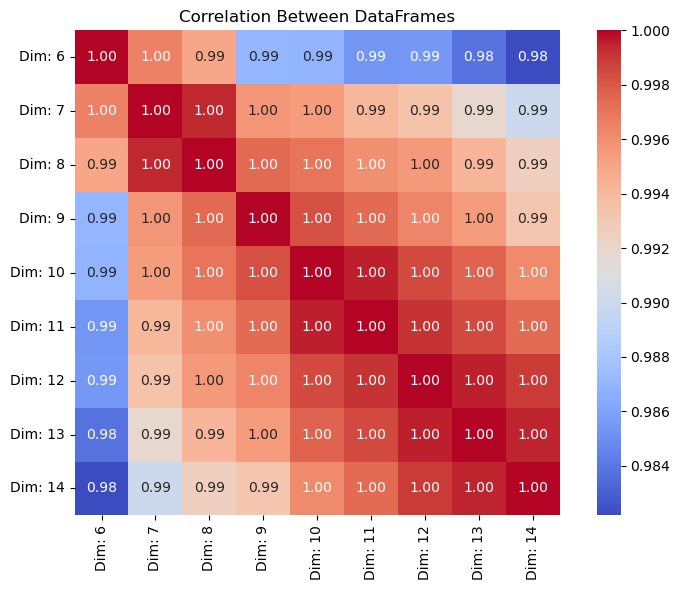

In [ ]:
labels = [f'Dim: {i+ 6}' for i in range(len(corr_matrix))]
corr_matrix.index = labels
corr_matrix.columns = labels

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Between DataFrames")
plt.tight_layout()
plt.show()

As we can see, a higher number of PC used does not significantly affect the results.